In [3]:
import json 
import numpy as np 
import seaborn as sns 
from pathlib import Path 
import matplotlib.pyplot as plt 
import pandas as pd 
import plot_utils
import networkx as nx 
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import RDLogger 

RDLogger.DisableLog('rdApp.*')

from importlib import reload
reload(plot_utils)

plot_utils.set_style()
ftype = '.pdf'

fig_dir = Path('figs')
fig_dir.mkdir(exist_ok=True, parents=True)

method_colors = {
    'Nonlinear': sns.color_palette("mako", n_colors=10).as_hex()[8],
    'Linear (iterative)': sns.color_palette("mako", n_colors=10).as_hex()[2],
    'Common': sns.color_palette("mako", n_colors=10).as_hex()[4],
}

method_styles = {
    'Linear (iterative)': '',
    'Nonlinear': (4,3), 
    'Common': (1,1)
}




### Functions

In [4]:
def get_params_and_summary(res_dir: Path):
    keys = [
        'bayes_iters', 'max_rxns', 'Number targets', 
        'Cumulative reward of selected compounds', 'Run time', 
        'Expected Reward', 'Number reaction steps (actual)', 'Average reaction score (actual)',
        'max_rxn_classes', 'reward_weight', 'reaction_weight', 'start_cost_weight']

    if not (res_dir / 'params.ini').exists(): 
        return 
    with open(res_dir / 'params.ini', 'r') as f: 
        lines = f.read().splitlines() 
    
    params = {'bayes_iters': 0,}
    for line in lines: 
        p, val = line.split(': ')
        try: 
            val = float(val)
        except: 
            continue  
        params[p] = val

    sol_dir = res_dir/'BEST_SOLUTION' if (res_dir/'BEST_SOLUTION').exists() else res_dir/'solution'
    if not sol_dir.exists(): 
        return 
    
    with open(sol_dir / 'summary.json', 'r') as f:
        summary = json.load(f)
    
    if 'Total Tuning Run Time' in summary: 
        summary['Run time'] = summary['Total Tuning Run Time']
    
    results = {key: val for key, val in {**params, **summary}.items() if key in keys}

    return results

def get_params_only(res_dir: Path): 

    with open(res_dir / 'params.ini', 'r') as f: 
        lines = f.read().splitlines() 
    
    params = {}
    for line in lines: 
        p, val = line.split(': ')
        try: 
            val = float(val)
        except: 
            continue  
        params[p] = val

    return params

def tanimoto_similarity(v1: np.array, v2: np.array):

    # Compute dot products and norms
    dot_product = np.dot(v1, v2)
    norm_vec1 = np.dot(v1, v1)
    norm_vec2 = np.dot(v2, v2)
    
    denom = norm_vec1 + norm_vec2 - dot_product

    return dot_product / denom

def smiles_to_fingerprint_arr(
    smiles_list: list[str],
    radius: int = 3, 
    fpSize: int = 2048,
) -> np.array:
    """ Converts a list of SMILES to a numpy array of fingerprints """

    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=fpSize)
    mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    fps = [mfpgen.GetCountFingerprintAsNumPy(m) for m in mols]
    return np.asarray(fps, dtype=float)

def fp_featurizer(smiles_list): 
    """ Generates a dictionary mapping SMILES in the design space to count Morgan fingerprints """
    fps = smiles_to_fingerprint_arr(smiles_list)
    featurizer = {
        smi: fps[i,:]
        for i, smi in enumerate(smiles_list)
    }
    return featurizer


### Plotting nonlinear vs linear

In [5]:
result_dir = Path('../../../results/automoldesigner_rxnconstr')
data = [
    get_params_and_summary(file) for file in result_dir.glob('*')
]
data = [d for d in data if d]
df = pd.DataFrame(data)
df['Method'] = ['Nonlinear' if d==0 else 'Linear (iterative)' for d in df['bayes_iters'] ]
df = df.sort_values(by='Method')

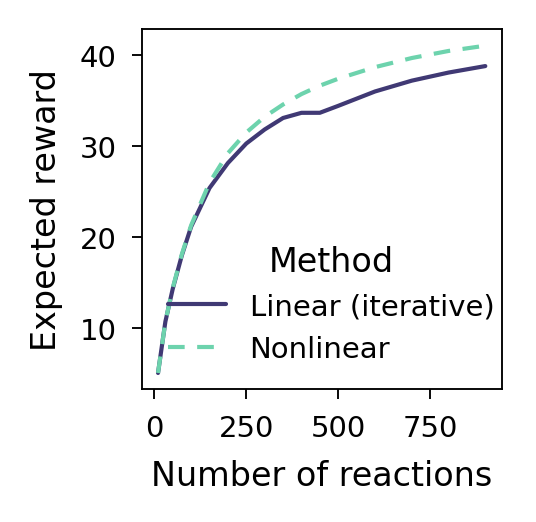

In [6]:
fig, ax = plt.subplots(1,1)
sns.lineplot(data=df, x='max_rxns', y='Expected Reward', hue='Method', style='Method', ax=ax, 
             palette=method_colors, dashes=method_styles, linewidth=1) 
plot_utils.set_size(ax=ax, w=1.2, h=1.2)
ax.set_xlabel('Number of reactions')
ax.set_ylabel('Expected reward')
fig.savefig(fig_dir/f'er_vs_nrxns{ftype}',bbox_inches='tight', dpi=200, transparent=True)

In [12]:
df

,bayes_iters,max_rxns,reaction_weight,reward_weight,start_cost_weight,Number targets,Cumulative reward of selected compounds,Run time,Expected Reward,Number reaction steps (actual),Average reaction score (actual),Method
33,20.0,300.0,1.0,1.0,1.0,123,41.467939,1365.748467,31.817355,299,0.924301,Linear (iterative)
18,20.0,600.0,1.0,1.0,1.0,228,56.698388,1312.234311,35.988301,600,0.866974,Linear (iterative)
32,20.0,800.0,1.0,1.0,1.0,294,60.106352,1343.901005,38.064751,800,0.877797,Linear (iterative)
15,20.0,10.0,1.0,1.0,1.0,9,5.526334,1134.965220,5.095198,10,0.946873,Linear (iterative)
24,20.0,200.0,1.0,1.0,1.0,83,33.924434,1334.600061,28.132490,200,0.943528,Linear (iterative)
12,20.0,700.0,1.0,1.0,1.0,259,58.505158,1347.266816,37.175315,700,0.874551,Linear (iterative)
26,20.0,100.0,1.0,1.0,1.0,47,24.305437,1308.473544,21.140523,100,0.950329,Linear (iterative)
22,20.0,450.0,1.0,1.0,1.0,177,52.283015,1264.200397,33.649988,450,0.867068,Linear (iterative)
9,20.0,30.0,1.0,1.0,1.0,20,11.817083,1213.222509,10.734278,30,0.953868,Linear (iterative)
20,20.0,250.0,1.0,1.0,1.0,102,37.771734,1425.134823,30.276312,250,0.937635,Linear (iterative)


In [29]:
min(df.loc[df.Method=='Nonlinear']['Run time'])

123.8996262550354

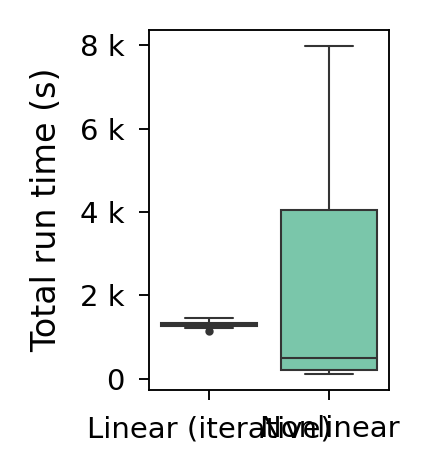

In [32]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1,1)
sns.boxplot(data=df, x="Method", y="Run time", hue="Method", ax=ax, linewidth=0.5, fliersize=1, palette=method_colors,) #, log_scale=True)
plot_utils.set_size(ax=ax, w=0.8, h=1.2)
ax.set_ylabel('Total run time (s)')
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

fig.savefig(fig_dir/f'time_vs_method{ftype}',bbox_inches='tight', dpi=200, transparent=True)


In [ ]:
df_common = df[['Method', 'max_rxns', 'Number targets']]
storage = []

for i in set(df_common['max_rxns']):
    res_dir_er = result_dir / f'er_{i:0.0f}'
    res_dir_bo = result_dir / f'bo_{i:0.0f}'

    with open(res_dir_er / 'solution' / 'solution_list_format.json', 'r') as f: 
        er_selections = set([entry['smiles'] for entry in json.load(f)['Targets']])

    with open(res_dir_bo / 'BEST_SOLUTION' / 'solution_list_format.json', 'r') as f: 
        bo_selections = set([entry['smiles'] for entry in json.load(f)['Targets']]) 
    
    storage.append({
        'Method': 'Common',
        'max_rxns': i, 
        'Number targets': len(er_selections & bo_selections)
    })

df_count = pd.concat([
    df_common, pd.DataFrame(storage)
])

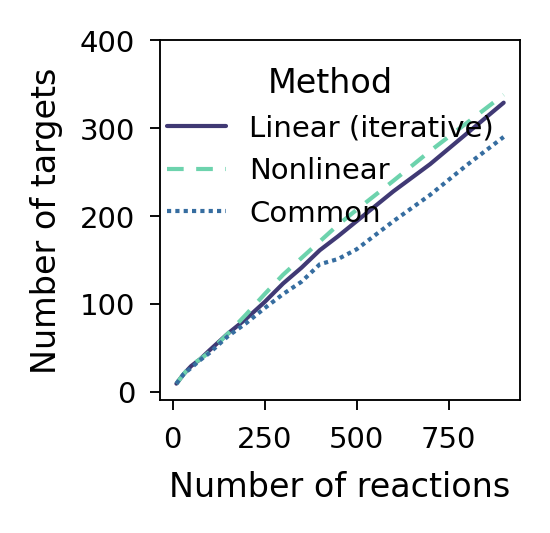

In [ ]:
fig, ax = plt.subplots(1,1)
sns.lineplot(data=df_count, x='max_rxns', y='Number targets', hue='Method', style='Method', ax=ax, 
             palette=method_colors, dashes = method_styles, linewidth=1) 
ax.set_ylim([-10, 400])
plot_utils.set_size(ax=ax, w=1.2, h=1.2)
ax.set_xlabel('Number of reactions')
ax.set_ylabel('Number of targets')
fig.savefig(fig_dir/f'targetcount{ftype}',bbox_inches='tight', dpi=200, transparent=True)


In [ ]:
# Screening weighting factors 

max_er = list(df.loc[(df['Number reaction steps (actual)']==500) & (df['bayes_iters']==0)]['Expected Reward'])[0]
result_dir = Path('../../../results/automoldesigner_vary_rew')
data = [
    get_params_and_summary(file) for file in result_dir.glob('*')
]
data = [d for d in data if d]
df_vary = pd.DataFrame(data)
df_vary['Method'] = ['Linear (iterative)']*len(df_vary)

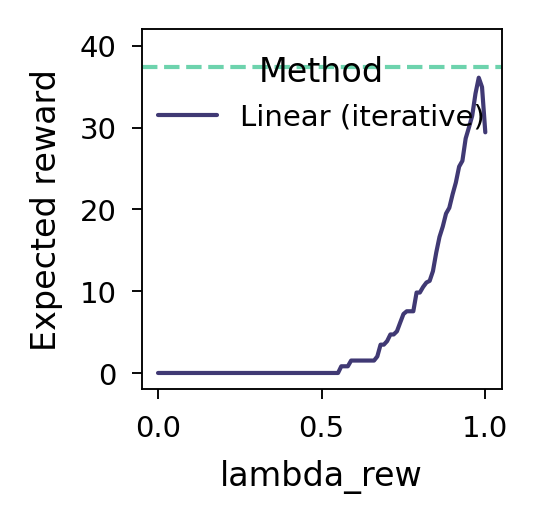

In [ ]:
fig, ax = plt.subplots(1,1)
sns.lineplot(data=df_vary, x='reward_weight', y='Expected Reward', hue='Method', style='Method', ax=ax, 
             palette=method_colors, dashes = method_styles, linewidth=1) 
ax.axhline(y=max_er, linewidth=1, color=method_colors['Nonlinear'], ls='--')
ax.set_ylim([-2,42])
plot_utils.set_size(ax=ax, w=1.2, h=1.2)
ax.set_xlabel('lambda_rew')
ax.set_ylabel('Expected reward')
fig.savefig(fig_dir/f'vary_reward_weight{ftype}',bbox_inches='tight', dpi=200, transparent=True)

### Diversity figures 

In [ ]:
method_colors.update({
    'div': sns.color_palette("mako", n_colors=10).as_hex()[3],
    'no_div': sns.color_palette("mako", n_colors=10).as_hex()[8],
})

target_df = pd.read_csv('../targets.csv')

smi_to_fp = fp_featurizer(target_df.SMILES)
fps_all = np.array(list(smi_to_fp.values()))

div_result_dir = Path('../../../results/automoldesigner_div')

#### Visualization

In [ ]:
with open(div_result_dir / 'weight_0' / 'BEST_SOLUTION' / 'solution_list_format.json', 'r') as f: 
    sel_smis_0 = [e['smiles'] for e in json.load(f)['Targets']]

with open(div_result_dir / 'weight_1.0' / 'solution' / 'solution_list_format.json', 'r') as f: 
    sel_smis_1 = [e['smiles'] for e in json.load(f)['Targets']]



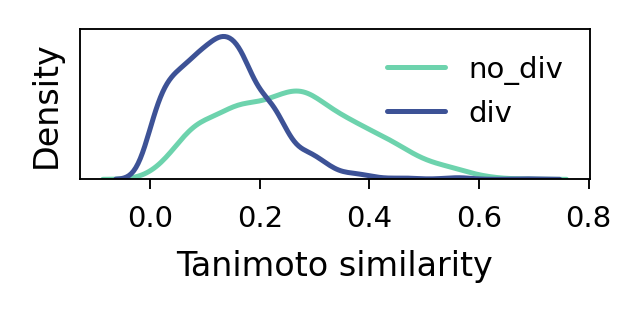

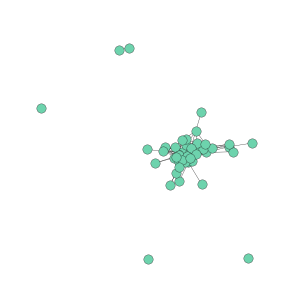

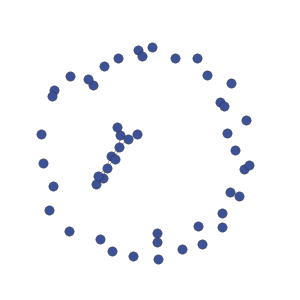

In [ ]:
fighist, axhist = plt.subplots(1,1)
for smis, name in zip([sel_smis_0, sel_smis_1], ['no_div', 'div']):
    # Create a graph
    G = nx.Graph()
    tani_min = 0.35

    # Add nodes (sequences) to the graph
    for i, smi in enumerate(smis):
        G.add_node(i, label=str(smi))

    # Add edges based on sequence similarity
    widths = []
    all_sims = []
    for i, smi_1 in enumerate(smis):
        for j, smi_2 in enumerate(smis):
            if i >= j: 
                continue 
            tani_sim = tanimoto_similarity(smi_to_fp[smi_1], smi_to_fp[smi_2])
            all_sims.append(tani_sim)
            if tani_sim > tani_min:
                G.add_edge(i, j, weight=tani_sim)
                widths.append(tani_sim)

    # Visualize the network
    pos = nx.spring_layout(G, seed=0) 
    fig, ax = plt.subplots(1,1)
    nx.draw(G, pos, width=0.075,
            node_color=method_colors[name], 
            node_size=5, 
            ax=ax, 
            edgecolors='k', linewidths=0.075)
    plot_utils.set_size(w=0.8, h=0.8, ax=ax,)
    fig.savefig(fig_dir/f'clustervis_{name}{ftype}',bbox_inches='tight', dpi=200, transparent=True)

    sns.kdeplot(data=all_sims, ax=axhist, color=method_colors[name], label=name)

plot_utils.set_size(w=1.7, h=0.5, ax=axhist)
axhist.legend()
axhist.set_xlabel('Tanimoto similarity')
axhist.tick_params(left=False)
axhist.set_yticks([])
fighist.savefig(fig_dir/f'tanihist_{name}{ftype}',bbox_inches='tight', dpi=200, transparent=True)


#### Number of clusters vs weighting factor 

In [ ]:
with open('clusters.json','r') as f: 
    clusters = json.load(f)
    
smi_to_cluster = {smi: c for c, smis in clusters.items() for smi in smis }
storage = []

for res_dir in div_result_dir.glob('weight*'): 

    sol_folder = 'BEST_SOLUTION' if (res_dir / 'BEST_SOLUTION').exists() else 'solution'

    with open(res_dir / sol_folder / 'solution_list_format.json', 'r') as f: 
        selections = [sel['smiles'] for sel in json.load(f)['Targets']]

    n_clusters = len(set(
        smi_to_cluster[sel] for sel in selections                
    ))

    with open(res_dir / sol_folder / 'summary.json', 'r') as f: 
        summary = json.load(f)

    storage.append({
        'Diversity weight': get_params_only(res_dir)['diversity_weight'],
        'Number of clusters': n_clusters,
        'Number of reactions': summary['Number reaction steps (actual)'], 
        'Average reaction score': summary['Average reaction score (actual)'],
        'Expected reward': summary['Expected Reward'],
    })

df = pd.DataFrame(storage)
    

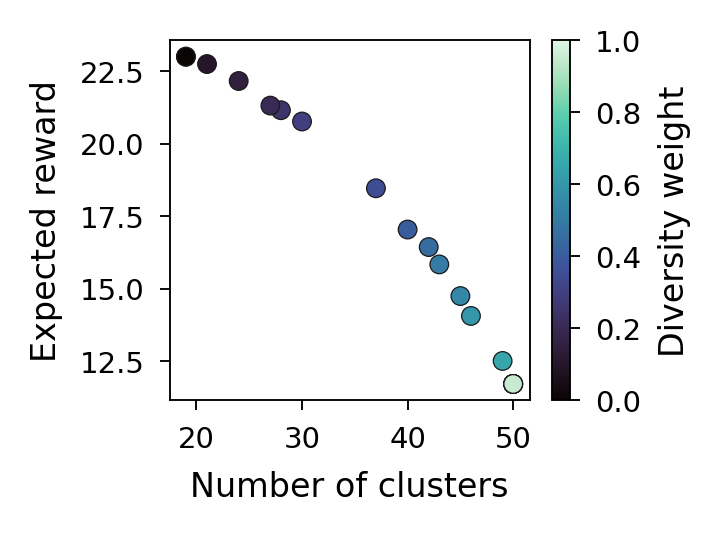

In [ ]:
fig, ax = plt.subplots(1,1)
cmap = sns.color_palette('mako', as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap) 
sns.scatterplot(data=df, ax=ax, x='Number of clusters', y='Expected reward', hue='Diversity weight', 
                hue_norm=sm.norm, palette=cmap, s=20, edgecolor='k', linewidth=0.3, legend=False)
plot_utils.set_size(1.5, 1.2, ax=ax)
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('Diversity weight')
fig.savefig(fig_dir/f'div1{ftype}',bbox_inches='tight', dpi=200, transparent=True)


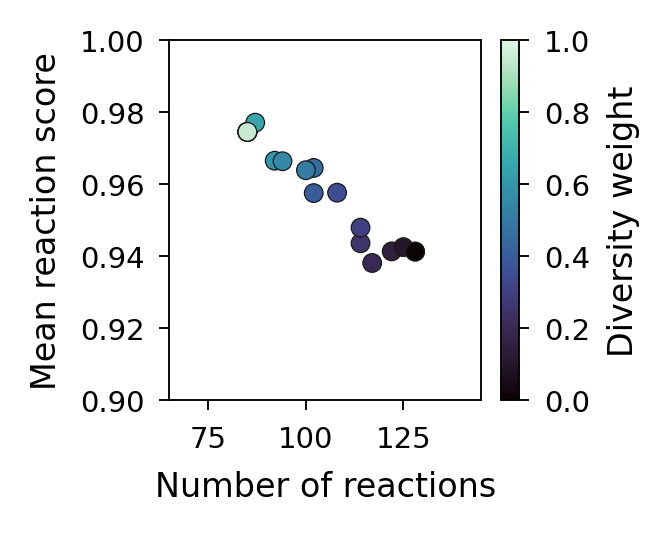

In [ ]:
fig, ax = plt.subplots(1,1)
cmap = sns.color_palette('mako', as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap) 
sns.scatterplot(data=df, ax=ax, x='Number of reactions', y='Average reaction score', hue='Diversity weight', 
                hue_norm=sm.norm, palette=cmap, s=20, edgecolor='k', linewidth=0.3, legend=False)
ax.set_ylim([0.9, 1])
ax.set_xlim([65, 145])
plot_utils.set_size(1.3, 1.2, ax=ax)
ax.set_ylabel('Mean reaction score')
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('Diversity weight')
fig.savefig(fig_dir/f'div2{ftype}',bbox_inches='tight', dpi=200, transparent=True)


### Reaction classification

#### Expected reward vs number of classes allowed 

In [ ]:
storage = []
for res_dir in Path('../../../results/automoldesigner_namerxn').glob('*'): 
    storage.append(get_params_and_summary(res_dir))

df_rxn = pd.DataFrame(storage)

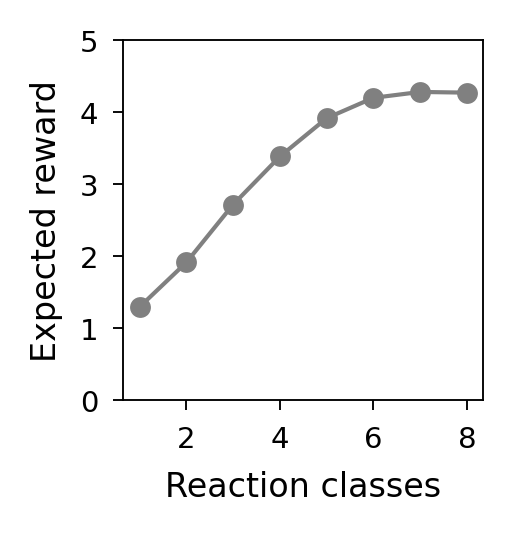

In [ ]:
fig, ax = plt.subplots(1,1)
sns.lineplot(data=df_rxn, x='max_rxn_classes', y='Expected Reward', ax=ax, 
             marker='o', c='gray', 
             dashes = False, markeredgecolor=None, 
             markeredgewidth=0, markersize=5, linewidth=1) 
ax.set_ylim([0, 5])
plot_utils.set_size(ax=ax, w=1.2, h=1.2)
ax.set_xlabel('Reaction classes')
ax.set_ylabel('Expected reward')
fig.savefig(fig_dir/f'er_vs_classes{ftype}',bbox_inches='tight', dpi=200, transparent=True)

### SI tables

In [ ]:
name_rxn_mapping = {
    '8.1.4': 'Alcohol to aldehyde oxidation',
    '10.1.2': 'Chlorination',
    '1.2.2': 'Aldehyde reductive imination',
    '1.3.7': 'Chloro N-arylation',
    '1.2.1': 'Aldehyde reductive amination',
    '3.10.1': 'Friedel-Crafts acylation',
    '9.7.12': 'Amino to isothiocyanato',
    '2.3.2': 'Isothiocyanate + amine thiourea coupling',
}

#### SI table for parallel chemistry figure 

In [ ]:
paths_names = {
    '../../../results/automoldesigner_namerxn/classes_8/BEST_SOLUTION/solution_list_format.json': '8_classes',
    '../../../results/automoldesigner_namerxn/classes_1/BEST_SOLUTION/solution_list_format.json': '1_class',
    '../../../results/automoldesigner_namerxn_diversity/div0.1_classes1/solution/solution_list_format.json': '1_class_diversity',
    '../../../results/automoldesigner_namerxn_diversity/div0_classes1/solution/solution_list_format.json': '1_class_no_diversity',
}

clusters = [False, False, True, True]

for (path, label), c in zip(paths_names.items(), clusters):  

    with open(path, 'r') as f: 
        solution = json.load(f)

    if c: 
        cluster_labels = {
            tar['smiles']: tar['clusters'][0]
            for tar in solution['Targets']
        }  
    rewards = {tar['smiles']: tar['reward'] for tar in solution['Targets']}

    storage = []

    for reaction in solution['Reactions']:
        if reaction['smiles'].startswith('>>'): 
            continue 

        prod = reaction['smiles'].split('>>')[-1]
        store = {
            'Reactant SMILES': reaction['smiles'].split('>>')[0],
            'Product SMILES': prod, 
            'Reaction likelihood score': f'{reaction['score']:0.3f}',
            'Reward of reaction product': f'{rewards[prod]:0.3f}' if prod in rewards else '--'
        }
        if c: 
            store['Cluster'] = '--'
            if prod in rewards: 
                store['Cluster'] = cluster_labels[prod].split('SimCluster_')[-1]
        else: 
            store['NameRxn Class'] = name_rxn_mapping[reaction['class'][0]]
        
        storage.append(store)

    df = pd.DataFrame(storage)

    str_df = df.to_latex(escape=False, index=False, multicolumn_format='c')
    outpath = fig_dir / f'si_table_{label}.txt'
    with open(outpath,'w') as f:
        f.writelines(str_df)
    
    df.to_csv(f'si_table_{label}.csv', index=False)

### SA score

In [ ]:
raw_data = pd.read_csv('../data/staph_targets_raw.csv')

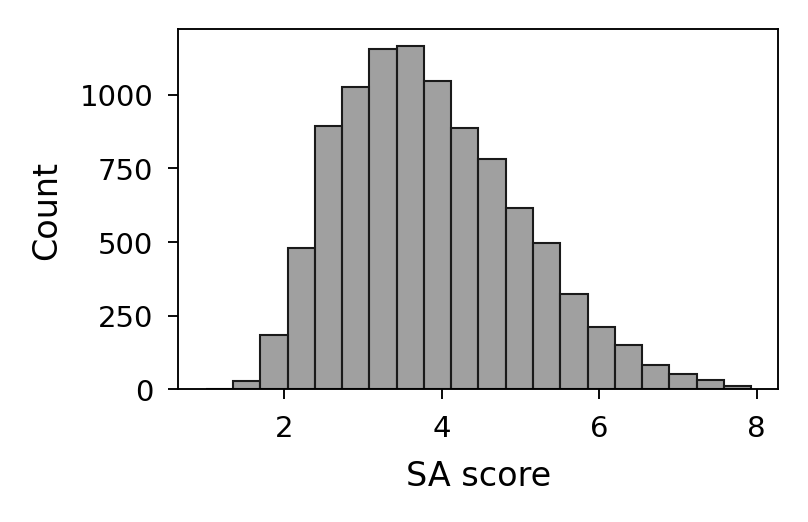

In [ ]:
fig, ax = plt.subplots(1,1)
sns.histplot(data=raw_data, x='SA score', bins=20, ax=ax, color='gray', edgecolor='k', linewidth=0.5)
plot_utils.set_size(ax=ax, w=2, h=1.2)
fig.savefig(fig_dir/f'sa_hist{ftype}',bbox_inches='tight', dpi=200, transparent=True)